Mounting Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Downloading the OpenPose repository from GitHub.



In [ ]:
git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'

Installing CMake.

In [ ]:
!wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
!tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local

In [ ]:
!git clone -q --depth 1 $git_repo_url

In [ ]:
!sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt

Installing all the dependencies.

In [ ]:
!apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev

Selecting previously unselected package libgflags2.2.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../00-libgflags2.2_2.2.1-1_amd64.deb ...
Unpacking libgflags2.2 (2.2.1-1) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../01-libgflags-dev_2.2.1-1_amd64.deb ...
Unpacking libgflags-dev (2.2.1-1) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../02-libgoogle-glog0v5_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.3.5-1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to unpack .../03-libgoogle-glog-dev_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog-dev (0.3.5-1) ...
Selecting previously unselected package libhdf5-serial-dev.
Preparing to unpack .../04-libhdf5-serial-dev_1.10.0-patch1+docs-4_all.deb ...
Unpacking libhdf5-serial-dev (1.10.0-patch1+docs-4) ...
Selecting previously unselected package libleveldb1v5:amd64.
Preparing to unpack ...

Building OpenPose. This may take a few minutes.

In [ ]:
!cd openpose && rm -rf build || true && mkdir build && cd build && cmake -DBUILD_PYTHON=ON .. && make -j`nproc`

-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- GCC detected, adding compile flags
-- GCC detected, adding compile flags
-- Looking for pthread.h
-- Looking for pthread.h - found
-- Looking for pthread_create
-- Looking for pthread_create - not found
-- Looking for pthread_create in pthreads
-- Looking for pthread_create in pthreads - not found
-- Looking for pthread_create in pthread
-- Looking for pthread_create in pthread - found
-- Found Threa

Installing HTTP server dependencies.

In [ ]:
!pip install fastapi nest-asyncio pyngrok uvicorn
!pip install python-multipart

     |████████████████████████████████| 51 kB 475 kB/s 
     |████████████████████████████████| 745 kB 10.3 MB/s 
     |████████████████████████████████| 54 kB 2.5 MB/s 
     |████████████████████████████████| 61 kB 239 kB/s 
     |████████████████████████████████| 10.1 MB 35.0 MB/s 
     |████████████████████████████████| 78 kB 5.7 MB/s 
     |████████████████████████████████| 54 kB 2.9 MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.1.0-py3-none-any.whl size=19006 sha256=a76e7fd057b37614784d629a45af723a8c55286fcdb27d8bde01257b2e9fc8c1
  Stored in directory: /root/.cache/pip/wheels/bf/e6/af/ccf6598ecefecd44104069371795cb9b3afbcd16987f6ccfb3
Successfully built pyngrok
  Created wheel for python-multipart: filename=python_multipart-0.0.5-py3-none-any.whl size=31678 sha256=ef9111f5b17c827e56b23f5d86bd3bf0a9b203247cdb5f3fd5a951d8e8e9c72b
  Stored in directory: /root/.cache/pip/wheels/2c/41/7c/bfd1c180534ffdcc0972f78c5758f89881602175d48a8bcd2c
Successfully built python-multipart


Importing reqquired libraries.

In [ ]:
from fastapi import FastAPI, File, UploadFile
from typing import List
import nest_asyncio
from pyngrok import ngrok
import uvicorn
import shutil
from datetime import datetime
import json, os, math
import matplotlib.pyplot as plt 

Utility functions.

In [ ]:
#salva os arquivos recebidos do POST em uma pasta
def save_files(files,path):
  get_ipython().system('mkdir '+ path)
  for image in files:
    with open(path + '/' + image.filename, "wb") as buffer:
      shutil.copyfileobj(image.file, buffer)

#detecção das poses (todo: passar parâmetros personalizados pelo POST)
def detect_poses(in_path,out_path):
  get_ipython().system('cd openpose && ./build/examples/openpose/openpose.bin --image_dir '+ in_path +' --write_json '+ out_path +' --display 0 --render_pose 0')

Extracting features and building descriptors.

In [ ]:
def extract_features(path, method='gait-hist'):
  parts = [(2,3),(5,6),(3,4),(6,7),(9,10),(12,13),(10,11),(13,14)]    #partes dos membros
  features_angles = []
  features_distances = []
  features_lengths = []
  max_l = 0
  maxdist = 0
  neck = 1
  #ordando os frames (json)
  frames = os.listdir(path)
  frames.sort()

  for part in parts:
    angles = []
    dists = []
    lengths = []
    #extrair angulos, distancias e comprimentos para cada parte dos membros
    for frame in frames:
        with open(path+'/'+frame, 'r') as f:
            keypoints = json.load(f)
        key = keypoints['people']
        if len(key) == 0:
            continue                    
        x0 = key[0]['pose_keypoints_2d'][part[0]*3]
        x1 = key[0]['pose_keypoints_2d'][part[1]*3]
        y0 = key[0]['pose_keypoints_2d'][part[0]*3+1]
        y1 = key[0]['pose_keypoints_2d'][part[1]*3+1]
        
        limb = (x1-x0, y1-y0)
        x2 = key[0]['pose_keypoints_2d'][3]
        x3 = key[0]['pose_keypoints_2d'][24]
        y2 = key[0]['pose_keypoints_2d'][4]
        y3 = key[0]['pose_keypoints_2d'][25]
        torso = (x3-x2, y3-y2)
        denom_len = math.sqrt(torso[0]**2 + torso[1]**2)

        neck_x = key[0]['pose_keypoints_2d'][neck*3]
        neck_y = key[0]['pose_keypoints_2d'][neck*3+1]

        ux = x1-x0  
        uy = y1-y0
        vx = 1
        vy = 0
        denom = max(key[0]['pose_keypoints_2d'][11*3+1]-key[0]['pose_keypoints_2d'][neck*3+1],key[0]['pose_keypoints_2d'][14*3+1]-key[0]['pose_keypoints_2d'][neck*3+1])
        if((x0 == 0 and y0 == 0) or (x1 == 0 and y1 == 0) or (vx == 0 and vy == 0) or denom_len == 0):#membro é um vetor nulo -> erro de detecção
            t = -1
            ro = 0
            l = 0
        else:
            t = math.acos((ux*vx+uy*vy)/(math.sqrt(ux*ux+uy*uy)*math.sqrt(vx*vx+vy*vy)))
            kx = x1 - neck_x
            ky = y1 - neck_y
            wx = neck_x - x0
            wy = neck_y - y0
            escalar = (ux*wx+uy*wy)/(math.sqrt(ux*ux+uy*uy)**2)
            projx = escalar*ux
            projy = escalar*uy
            vet_ortx = wx - projx
            vet_orty = wy - projy
            ro = math.sqrt(vet_ortx**2+vet_orty**2)#/denom
            l = math.sqrt(limb[0]**2 + limb[1]**2)/denom_len
            maxdist = max(maxdist,ro)
            max_l = max(l,max_l)
        angles.append(t) 
        dists.append(math.log2(ro+1)) #usando log pois os valores menores são mais importantes
        lengths.append(l)   
    features_angles.append(angles)
    features_distances.append(dists)
    features_lengths.append(lengths)
  return features_angles, features_distances, features_lengths, maxdist, max_l

In [ ]:
def create_descriptors(angles, distances, lengths, nVals=16, max_dist=275.00,max_len=1.25):
  hist_angles, bins1, paches1 = plt.hist(angles, nVals,range=(-1,math.pi))
  hist_dist, bins2, paches2 = plt.hist(distances, nVals,range=(0,math.log2(max_dist+1)))
  hist_lens, bins3, paches3 = plt.hist(lengths, nVals,range=(0,max_len))
  for l in range(0,len(hist_angles)):
        for c in range(0,len(hist_angles[l])):
            hist_angles[l][c] = hist_angles[l][c]/len(angles[l])
            hist_dist[l][c] = hist_dist[l][c]/len(distances[l])
            hist_lens[l][c] = hist_lens[l][c]/len(lengths[l])
  return hist_angles, hist_dist, hist_lens
  #return [hist_angles, hist_dist, hist_lens]

Creating HTTP server.

In [ ]:
class Server():
  def __init__(self,app=FastAPI()):
    self.app = app
    @app.get('/index')
    async def home():
      return "Hello World"

    @app.post("/extractfeatures/")
    async def create_upload_files(files: List[UploadFile] = File(...)):
      now = datetime.now()
      folder_name = now.strftime("%H-%M-%S")
      in_path = '/content/drive/MyDrive/TCC/'+folder_name
      out_path = '/content/drive/MyDrive/TCC/'+folder_name+'/keypoints'
      try:
        save_files(files=files, path=in_path)
        detect_poses(in_path=in_path,out_path=out_path)
        angles, distances, lengths, max_d, max_l = extract_features(out_path)
        hist_angles, hist_dist, hist_lens = create_descriptors(angles, distances, lengths)
      finally:
        get_ipython().system('rm -rf '+ in_path)
      return {"angles":hist_angles.tolist(), "distances":hist_dist.tolist(), "lengths":hist_lens.tolist()}
  
  def run_server(self,sv_port = 8000):
    ngrok_tunnel = ngrok.connect(sv_port)
    print('Public URL:', ngrok_tunnel.public_url)
    nest_asyncio.apply()
    uvicorn.run(self.app, port=sv_port)

Running server.

Public URL: http://de3f-34-67-204-210.ngrok.io


INFO:     Started server process [74]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 17.854493 seconds.
INFO:     177.52.29.165:0 - "POST /extractfeatures/ HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [74]


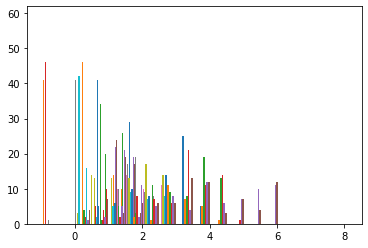

In [ ]:
app = Server()
app.run_server()